In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")
figsize(7, 7)

Populating the interactive namespace from numpy and matplotlib


# PyTorch

"Tensors and Dynamic neural networks in Python with strong GPU acceleration"

- like Matlab or Numpy, but with GPU support
- automatic, dynamic differentiation and gradient descent
- some frameworks for neural networks

# SIMPLE COMPUTATIONS

In [2]:
# simple "tensors" (multidimensional numerical arrays) in Torch

import torch
data = torch.rand(256, 256)
print(data)

tensor([[0.7949, 0.8256, 0.5195,  ..., 0.3768, 0.0879, 0.3368],
        [0.2525, 0.6381, 0.4622,  ..., 0.0522, 0.7279, 0.8069],
        [0.9612, 0.2736, 0.2947,  ..., 0.7928, 0.0497, 0.5581],
        ...,
        [0.2521, 0.3845, 0.6467,  ..., 0.8429, 0.9570, 0.6316],
        [0.1607, 0.0619, 0.4903,  ..., 0.7387, 0.9310, 0.5125],
        [0.5149, 0.1543, 0.7354,  ..., 0.8578, 0.4714, 0.2112]])


In [3]:
# a pointless GPU computation

if torch.has_cuda:
    data = torch.rand(256, 256).cuda()
    out = data
    for i in range(100):
        out = torch.mm(data, out)
        out /= out.norm()
    imshow(out.cpu().numpy())
else:
    print("CUDA not available")

CUDA not available


# PyTorch 

- standard set of numerical operations
- similar primitives to Numpy, Matlab
- operations run on CPU and GPU
- GPU operations use CUDA, cuDNN, some third party kernels
- direct binding: you call a numerical function, it calls the kernel

# AUTOMATIC DIFFERENTIATION

In [4]:
def tshow(image, **kw):
    if image.ndimension()==2:
        imshow(image.detach().cpu().numpy(), **kw)
    elif image.ndimension()==3:
        if image.shape[0]==1:
            tshow(image[0])
        else:
            imshow(image.detach().cpu().permute(1, 2, 0).numpy(), **kw)
    elif image.ndimension()==4:
        tshow(image[0])

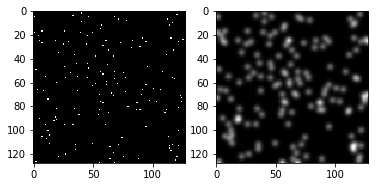

In [5]:
def generate_pair():
    image = (torch.rand((128, 128)) > 0.99).type(torch.float)
    import scipy.ndimage as ndi
    target = torch.tensor(ndi.gaussian_filter(image.numpy(), 2.0))
    return image, target

image, target = generate_pair()
subplot(121); tshow(image); subplot(122); tshow(target)

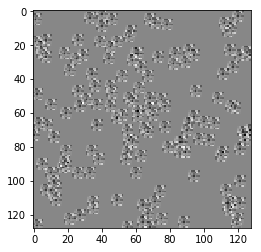

In [6]:
#### 2D Convolutions

import torch.nn.functional as F

x = image[None, None, :, :]
y = target[None, None, :, :]

w = torch.randn(1, 1, 7, 7)
w.requires_grad = True
b = torch.rand(1)
b.requires_grad = True

y_predicted = F.conv2d(x, w, padding=3) + b[None, :, None, None]

tshow(y_predicted)

In [7]:
w

tensor([[[[ 0.1052,  1.9302,  1.2662, -0.8087,  0.5095,  0.8963,  0.0430],
          [ 0.2265, -0.1577,  0.0197,  0.4447,  0.2839,  1.2390, -0.9656],
          [ 0.2440,  0.4093,  0.5766, -0.1442,  0.3397, -0.0448, -1.1121],
          [-0.9020, -0.7662, -0.0028, -2.1963, -0.5512,  0.7659,  1.4795],
          [ 0.2731,  0.0190, -0.0607, -0.8164,  0.2865, -0.3174,  0.7439],
          [-0.0986,  2.0523, -1.1628, -0.5351, -0.3523,  0.4925,  0.4643],
          [-1.2388,  1.3237,  1.2892, -1.5168, -1.3803,  0.7781,  0.1441]]]],
       requires_grad=True)

In [8]:
w.grad

In [9]:
# Computing the Error

err = ((y_predicted - y)**2).sum()
print(err)

err.backward(retain_graph=True)
print(w.grad)
print(b.grad)

tensor(6468.4961, grad_fn=<SumBackward0>)
tensor([[[[  91.6143,  591.8640,  433.6011, -182.5936,  183.8963,  305.1615,
             68.6536],
          [ 130.4260,  -28.4420,   47.0689,  186.6925,  163.8241,  397.8654,
           -201.7505],
          [ 153.5618,  186.0281,  221.1792,   28.1919,  165.3543,   38.3148,
           -264.3254],
          [-206.2096, -166.8671,   53.6520, -589.7891, -102.6573,  298.4451,
            486.5048],
          [ 157.2336,   67.6460,   35.1455, -144.7549,  147.0531,  -41.2445,
            266.0794],
          [  49.0761,  643.8719, -280.1640, -103.7804,  -38.1658,  181.2175,
            210.0840],
          [-309.7282,  444.0677,  441.7428, -388.9083, -330.1401,  289.1100,
             91.7840]]]])
tensor([7523.0078])


In [10]:
from graphviz import Digraph
def make_dot(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    param_map = {id(v): k for k, v in params.items()}
    print(param_map)
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='9',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12", rankdir="LR"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

{139806263414144: 'w', 139806263414360: 'x', 139806263379504: 'b'}


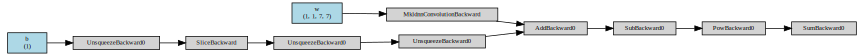

In [11]:
make_dot(err, dict(w=w, x=x, b=b))

# PyTorch Autograd Summary

- Tensors $\rightarrow$ Variables
- PyTorch keeps track of derivatives
- computation graphs can be completely dynamic
- propagate derivatives backwards using `x.backward()`
- access gradients using `x.grad`

# SIMPLE LEARNING

In [14]:
from torch import optim
import torch.nn.functional as F

x, y = generate_pair()
w = torch.randn(1, 1, 7, 7)
w.requires_grad = True

for i in range(5000):
    if w.grad is not None: w.grad.fill_(0)
    y_predicted = F.conv2d(x[None, None, :, :], w, padding=3)
    err = ((y_predicted - y[None, None, :, :])**2).sum()
    err.backward()
    w.data -= 1e-5 * w.grad
    if i%1000==0: print(f"{i:6d} {err.item():.3f}")

     0 7202.006
  1000 21.088
  2000 0.223
  3000 0.154
  4000 0.154


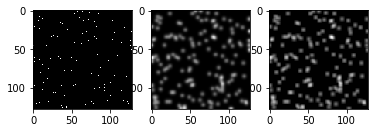

In [15]:
# input, desired output, learned output via gradient descent
subplot(131); tshow(x); subplot(132); tshow(y); subplot(133); tshow(y_predicted)

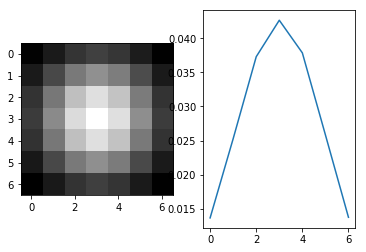

In [16]:
subplot(121); tshow(w); subplot(122); plot(w[0, 0, 3, :].detach().numpy())

# Learning a Linear Filter with Layers

- above example used gradient descent using completely functional computations
- a `Conv2d` layer is the same as a linear filter
- let's see whether we can learn this using PyTorch
- this uses all the components we need to train more complex models in PyTorch

In [17]:
from torch import nn, optim

# the "model" is just a single convolutional layer
model = nn.Conv2d(1, 1, (17, 17), padding=8)

# the loss is MSE loss
criterion = nn.MSELoss()

In [18]:
x, y = generate_pair()

for i in range(5000):
    
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    optimizer.zero_grad()
    
    y_predicted = model(x[None, None, :, :])
    
    loss = criterion(y[None, None, :, :], y_predicted)
    if i%500==0: print(i, loss.item())
    loss.backward()
    
    optimizer.step()

0 0.0035373142454773188
500 0.0004726290353573859
1000 7.554329204140231e-05
1500 1.4884694792272057e-05
2000 5.0958724386873655e-06
2500 3.4347010569035774e-06
3000 3.140114131383598e-06
3500 3.085898242716212e-06
4000 3.075610720770783e-06
4500 3.073610059800558e-06


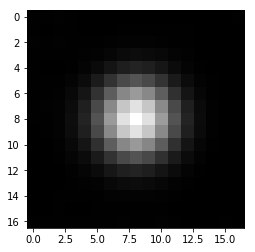

In [19]:
# display the learned kernel
parameters = list(model.parameters())
imshow(parameters[0].data[0,0].cpu().numpy())

# Torch "Modules" / "Layers"

In [20]:
import torch.functional as F

class Linear(nn.Module):
    def __init__(self, ninput, noutput):
        self.weights = Parameter(torch.randn(noutput, ninput))
    def forward(self, x):
        return F.linear(x, self.weights)
    # NB: no "backward" method needed

# Composition of Torch Layers

In [21]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# SHAPE INFERENCE, INPUT, REORDER

In [22]:
# git@github.com:tmbdev/tochmore

from torchmore import layers
from torchmore import flex

In [23]:
# model with flex layers

from torchmore import flex

model = nn.Sequential(
    flex.Conv2d(16, 3, padding=1),
    flex.BatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    flex.Conv2d(16, 3, padding=1),
    flex.BatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)  
)
model

Sequential(
  (0): Flex:None
  (1): Flex:None
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flex:None
  (5): Flex:None
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [24]:
# shape inference on first propagation

with torch.no_grad():
    model.forward(torch.randn(1, 1, 64, 64))

model

Sequential(
  (0): Flex:Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Flex:BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flex:Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Flex:BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [25]:
# removing the flex layers and turning this into a standard model

flex.freeze(model)

model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [26]:
# building abstractions

def conv2d(d, r=3, mp=None):
    result = [
        flex.Conv2d(16, r, padding=r//2),
        flex.BatchNorm2d(),
        nn.ReLU()
    ]
    if mp is not None: result += [nn.MaxPool2d(mp)]
    return result

model = nn.Sequential(
    *conv2d(16),
    *conv2d(32, mp=2)
)
flex.shape_inference(model, (1, 1, 64, 64))
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [27]:
# Input layers

model = nn.Sequential(
    layers.Input(assume="BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2)
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
# Fun, Reorder layers

model = nn.Sequential(
    layers.Input(assume="BDHW", sizes=((1, 256), 3, None, None), dtype=torch.float32),
    *conv2d(16, 7, mp=2),
    *conv2d(32, mp=2),
    layers.Fun("lambda x: x.sum(1)"),
    layers.Reorder("BDL", "LBD")
)

flex.shape_inference(model, (1, 3, 64, 64))
model

Sequential(
  (0): Input(BDHW->BDHW torch.float32 None cpu ((1, 256), 3, None, None))
  (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Fun None lambda x: x.sum(1)
  (10): Reorder("BDL", "LBD")
)

# Summary of Torch "Modules" and Training

- training uses modules, criteria, and optimizers
- modules (nn.Module) keep track of parameters and compute in the forward method
- criteria compute the differences between two outputs and return a scalar loss
- optimizers initiate gradient computation and then update the model parameters

# PYTORCH VS OTHERS

# Common Deep Learning Frameworks

Primary:

- TensorFlow
- PyTorch (old: Torch)
- Caffe 2 (old: Caffe)
- mxnet
- Chainer

Derived:

- Keras
- Theano

# TensorFlow

- superficially like PyTorch, but internally very different
- core is a dataflow language, completely separate from Python

Issues:
- tons of code between you and the kernels
- many custom written Google kernels
- memory hungry
- RNN support is worse

# PyTorch

Issues:

- Python multithreading is poor, therefore...
- limited ability to write high performance multi-GPU code

Potential Solutions:
- port to IronPython (C#, .NET)
- future, better Python JIT/compilers

# Future?

- both PyTorch and Tensorflow have serious limitations
- either they will substantially, or new frameworks will come around